In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
sns.set()
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model, layers
from keras import backend as K

In [2]:
# Define helper functions

def f1(y_true, y_pred):
  """
  Function that calculates and returns
  f1_score using Precision and Recall
  """

  def precision(y_true, y_pred):
    """
    Function that calculates and returns precision
    """
    p.update_state(y_true, y_pred)
    return p.result()
  
  def recall(y_true, y_pred):
    """
    Function that calculates and returns recall
    """
    r.update_state(y_true, y_pred)
    return r.result()
  
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)

  return 100 * 2 * ((precision*recall) / (precision + recall))


def custom_loss(pos_weights, neg_weights, epsilon=1e-7):
  """
  Function that takes class weights and
  returns a weighted loss.
  """

  def weighted_loss(y_true, y_pred):
    """
    Function that calculates weighted loss.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    loss = 0.0

    for i in range(len(pos_weights)):
      loss += -K.mean((pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i]+epsilon)) + (neg_weights[i] * (1.0-y_true[:, i]) * K.log(1.0-y_pred[:, i]+epsilon)))
    
    return loss

  return weighted_loss


def get_weights(df):
  """
  Function that calculates and
  returns class weights.
  """

  samples = df.shape[0]
  pos_weights = np.sum(df == 0, axis = 0)/samples
  neg_weights = np.sum(df == 1, axis = 0)/samples

  return pos_weights, neg_weights


def preprocess(img):
  """
  Function that processes images for
  model prediction.
  """

  path = os.path.join(test_dir, img)
  this = image.load_img(path=path, target_size=(331,331))
  x = image.img_to_array(this)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  return x


def decode(prediction):
  """
  Function that decodes model predictions.
  Returns class label with the highest probability.
  """
  top_pred = np.argmax(prediction)
  return labels[top_pred]

In [3]:
# Import training data

train = pd.read_csv('drive/MyDrive/dataset/train.csv')
train.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [4]:
# Check for missing values

train.isnull().any()

Image    False
Class    False
dtype: bool

In [5]:
# Number of class labels

labels = train.Class.unique().tolist()
labels

['Miscellaneous', 'Candle', 'Snowman', 'Airplane', 'Christmas_Tree', 'Jacket']

In [6]:
# Number of instances of each class

class_counts = train.Class.value_counts()
class_counts

Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: Class, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


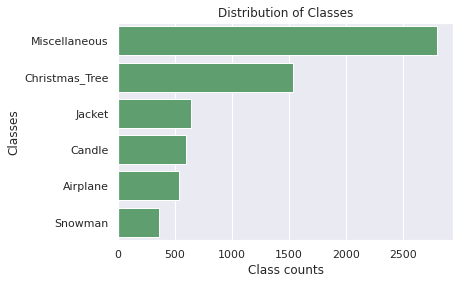

In [7]:
# Plot class distribution

sns.barplot(class_counts.values, class_counts.index, color='g')
plt.title('Distribution of Classes')
plt.xlabel('Class counts')
plt.ylabel('Classes')
plt.show()

In [8]:
# One-hot encoding

train[labels] = 0

for label in labels:
  for idx in range(len(train.Class)):
    if train.Class[idx] == label:
      train[label][idx] = 1
    else:
      train[label][idx] = 0

train.drop('Class', axis=1, inplace=True)
train = train.sample(frac=1)                 # Shuffle the data
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Image,Miscellaneous,Candle,Snowman,Airplane,Christmas_Tree,Jacket
2170,image3816.jpg,0,0,0,0,0,1
3944,image5843.jpg,0,0,0,1,0,0
2818,image7965.jpg,0,0,0,0,0,1
2559,image9127.jpg,0,0,1,0,0,0
2330,image5136.jpg,0,0,0,0,0,1


In [9]:
# Split the training set into train and validation splits (90:10)

split = int(len(train) * 0.9)
train_df = train.iloc[:split]
val_df = train.iloc[split:]

In [10]:
# Data generators

# Image augmentation for train images
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255.)

In [11]:
train_dir = 'drive/MyDrive/dataset/train'
test_dir = 'drive/MyDrive/dataset/test'

# Retrieve test images
test_images = os.listdir(test_dir)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    directory = train_dir,
                                                    x_col = 'Image',
                                                    y_col = labels,
                                                    target_size = (331,331),
                                                    class_mode = 'raw',
                                                    batch_size = 32)

val_generator = val_datagen.flow_from_dataframe(dataframe = val_df,
                                                directory = train_dir,
                                                x_col = 'Image',
                                                y_col = labels,
                                                target_size = (331,331),
                                                class_mode = 'raw',
                                                batch_size = 32)

Found 5822 validated image filenames.
Found 647 validated image filenames.


In [12]:
# Get class weights
pos_weights, neg_weights = get_weights(train_generator.labels)
pos_weights = pos_weights.astype(np.float32)
neg_weights = neg_weights.astype(np.float32)

# Instantiate precision and recall metric objects
p = Precision()
r = Recall()

# Insantiate early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=3,
                                        mode='min')

In [13]:
# Instantiate base model
pre_trained_model = NASNetLarge(input_shape=(331, 331, 3),
                                include_top = False,
                                weights = 'imagenet')

# Freeze layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# Add pooling, dropout and dense layers
output = pre_trained_model.output
output = layers.GlobalAveragePooling2D()(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dropout(0.2)(output)
output = layers.Dense(6, activation='softmax')(output)

# Create model
model = Model(pre_trained_model.input, output)

# Compile model with custom loss and metric
model.compile(optimizer='adam',
              loss = custom_loss(pos_weights, neg_weights),
              metrics = [f1])

# Train model
model.fit(train_generator,
          validation_data = val_generator,
          epochs = 20,
          callbacks=[early_stopping_callback])

Epoch 1/20
182/182 [==============================] - 244s 1s/step - loss: 0.9565 - f1: nan - val_loss: 0.4353 - val_f1: 67.0134
Epoch 2/20
182/182 [==============================] - 218s 1s/step - loss: 0.5766 - f1: 68.8377 - val_loss: 0.3740 - val_f1: 71.3754
Epoch 3/20
182/182 [==============================] - 216s 1s/step - loss: 0.5560 - f1: 72.1585 - val_loss: 0.3724 - val_f1: 73.4411
Epoch 4/20
182/182 [==============================] - 215s 1s/step - loss: 0.5093 - f1: 73.9564 - val_loss: 0.3079 - val_f1: 74.7736
Epoch 5/20
182/182 [==============================] - 214s 1s/step - loss: 0.4742 - f1: 75.2190 - val_loss: 0.2791 - val_f1: 75.8089
Epoch 6/20
182/182 [==============================] - 213s 1s/step - loss: 0.4629 - f1: 76.1151 - val_loss: 0.3142 - val_f1: 76.4388
Epoch 7/20
182/182 [==============================] - 213s 1s/step - loss: 0.4499 - f1: 76.7137 - val_loss: 0.3260 - val_f1: 77.2035
Epoch 8/20
182/182 [==============================] - 213s 1s/step - loss

In [14]:
# Fine-tuning

# Unfreeze last few layers of the model
for layer in model.layers[:-2]:
  layer.trainable = False
for layer in model.layers[-2:]:
  layer.trainable = True

# Re-compile model with SDG and low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss=custom_loss(pos_weights, neg_weights),
              metrics = [f1])

# Re-train model with new layers
model.fit(train_generator,
          validation_data = val_generator,
          epochs = 50,
          callbacks=[early_stopping_callback])

Epoch 1/50
182/182 [==============================] - 231s 1s/step - loss: 0.4312 - f1: 77.9058 - val_loss: 0.3009 - val_f1: 78.3234
Epoch 2/50
182/182 [==============================] - 212s 1s/step - loss: 0.4283 - f1: 78.4839 - val_loss: 0.2873 - val_f1: 78.8026
Epoch 3/50
182/182 [==============================] - 212s 1s/step - loss: 0.3976 - f1: 78.9383 - val_loss: 0.2803 - val_f1: 79.2535
Epoch 4/50
182/182 [==============================] - 212s 1s/step - loss: 0.3937 - f1: 79.3859 - val_loss: 0.2779 - val_f1: 79.5950
Epoch 5/50
182/182 [==============================] - 212s 1s/step - loss: 0.3744 - f1: 79.7166 - val_loss: 0.2731 - val_f1: 79.9668
Epoch 6/50
182/182 [==============================] - 212s 1s/step - loss: 0.3919 - f1: 80.0415 - val_loss: 0.2731 - val_f1: 80.2726
Epoch 7/50
182/182 [==============================] - 214s 1s/step - loss: 0.3592 - f1: 80.3857 - val_loss: 0.2717 - val_f1: 80.5725
Epoch 8/50
182/182 [==============================] - 213s 1s/step - 

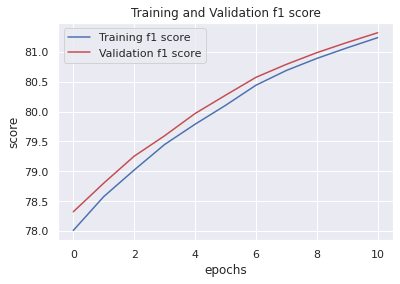

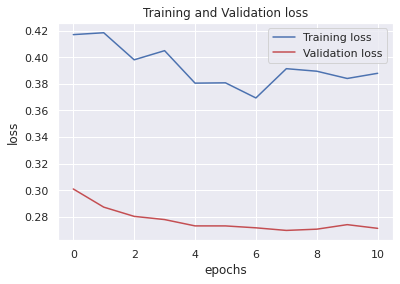

In [15]:
loss =  model.history.history['loss']
f1_score = model.history.history['f1']
val_loss = model.history.history['val_loss']
val_f1_score = model.history.history['val_f1']

epochs = range(len(loss))

# Plot training and validation f1_score
plt.plot(epochs, f1_score, 'b', label='Training f1 score')
plt.plot(epochs, val_f1_score, 'r', label='Validation f1 score')
plt.xlabel('epochs')
plt.ylabel('score')
plt.title('Training and Validation f1 score')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [16]:
# Make predictions on test images
test = map(preprocess, test_images)
class_probs = model.predict(test)
class_preds = map(decode, class_probs)
final_result = np.array([test_images, list(class_preds)], dtype='object').T

# Create final submission csv file
submission = pd.DataFrame(data = final_result, columns = ['Image', 'Class'])
submission.to_csv( 'submission.csv')